# Tutorial 2 - Disks with Elevated Emission Surfaces

This Notebook deals with disks where the vertical structure can clearly be resolved. This is fairly common now that ALMA observations of bright $^{12}{\rm CO}$ emission are routinely achieving angular resolutions of a few hundreds of milliarcseconds.

In [1]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from eddy import rotationmap

## HD 163296 - A Geometrically Thick Disk

For this tutorial we will look at the disk around HD 163296. We'll use data from the DSHARP project, with the data described in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available [here](https://bulk.cv.nrao.edu/almadata/lp/DSHARP/). There are many different ways of collapsing a cube to a velocity map and with various different programs. For now, we'll use ones collapsed using [`bettermoments`](https://bettermoments.readthedocs.io/en/latest) and are available from the [eddy Dataverse](https://dataverse.harvard.edu/dataverse/eddy).

Load up the data and inspect it.

Assuming uncertainties in ../../cubes/HD163296_CO_dv0.fits.


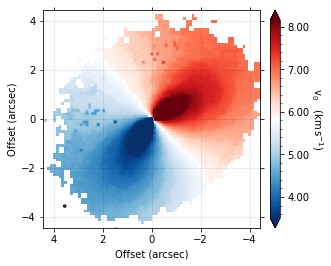

In [2]:
cube = rotationmap(path='../../cubes/HD163296_CO_v0.fits',
                   downsample='beam',
                   FOV=9.0)
cube.plot_data()

### A 2D Fit

To begin, we can fit a simple 2D model to the data, just as we did [for TW Hya](www.google.com). Note here we have used `optimize=False` to skip the initial optimization of the free parameters. As you will see, this is because the model is actually a poor description of the data and the current implementation will almost certaintly fail.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].


100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]


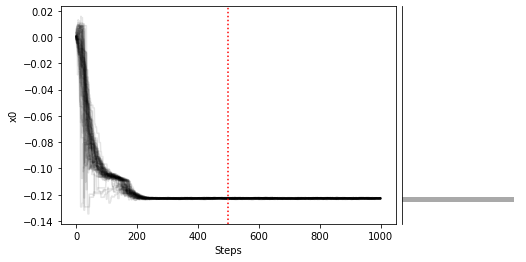

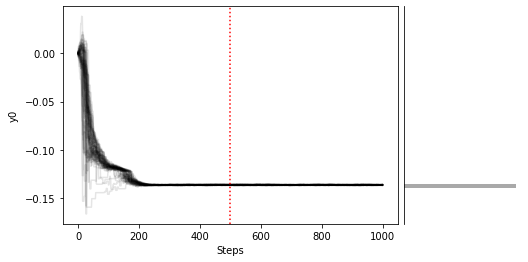

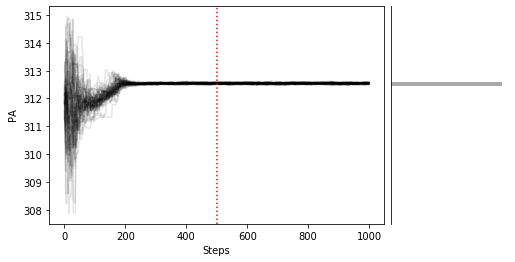

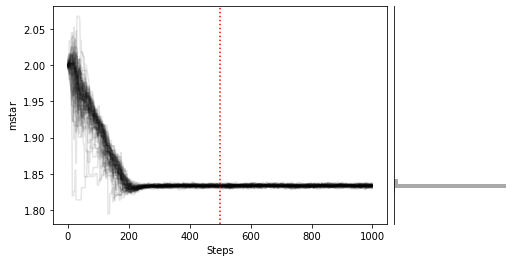

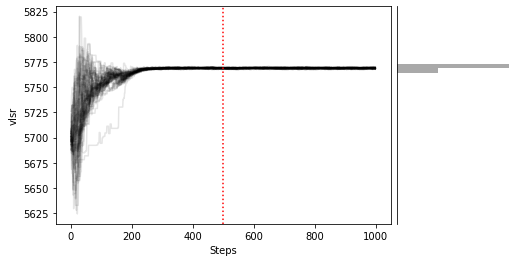

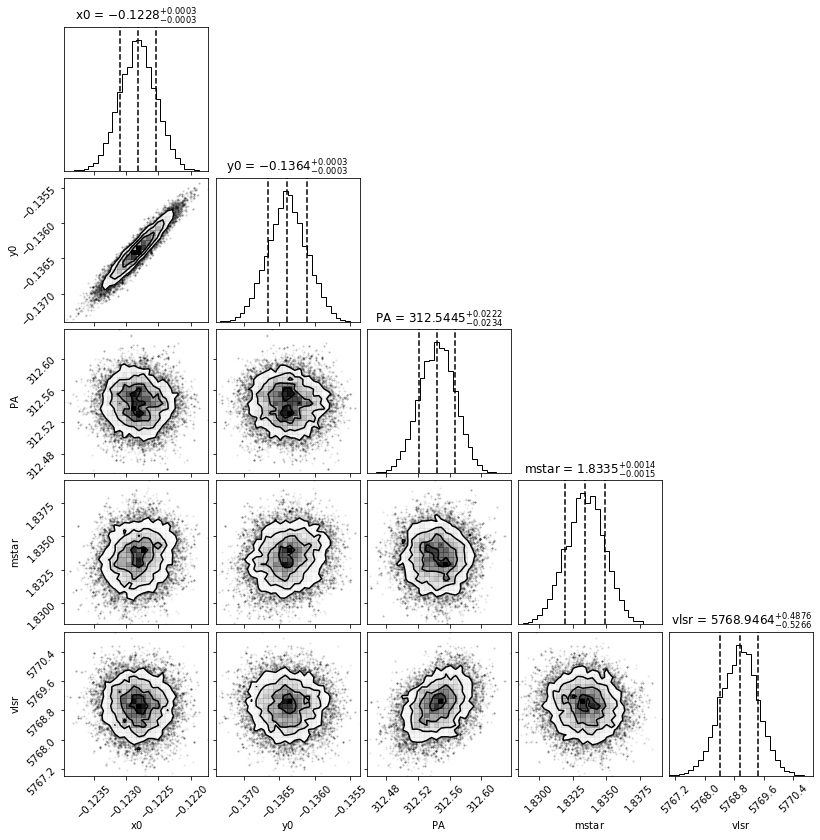

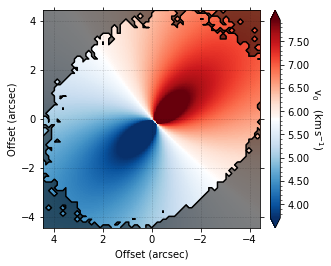

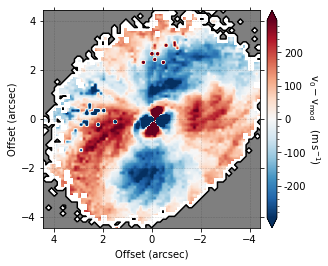

In [3]:
params = {}

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 312., 2.0, 5.7e3]

params['inc'] = 46.7    
params['dist'] = 101.0

samples = cube.fit_map(p0=p0, params=params, optimize=False,
                       nwalkers=64, nburnin=500, nsteps=500)

The walkers clearly converge to a best-fit model, but from the residual plot, it is clear this is not a good representation of the data. There are four main residual features we can identify here, and interpret with the help of the Appendices from [Teague et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884L..56T/abstract) and [Yen & Gu (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...905...89Y/abstract):

1) A quadrupole feature in the inner disk, likely because the model is not centered. Indeed, the posteriors for both $x_0$ and $y_0$ have shifted the model center along the minor axis. As we will see later, this is due to the 3D nature of the disk.

2) A ringed feature with a positive residual along the red-shifted major axis and a negative residual along the blue-shifted side. This is highly suggestive of a ring of faster rotating gas. For HD 163296, this is highly likely to be associated to the surface density perturbations traced by the gas and continuum [(Teague et al., 2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..12T/abstract).

3) A larger quadrupole feature in the outer disk due to a misspecified emission surface. Again, it is clear that a geometrically thin model is not a good description of HD 163296.

4) An arc-shaped residual along the North East edge of the disk. This is contamination from the back side of the disk. Here the line emission arises from _behind_ the continuum (the 'back side' of the disk), while the model assumes all the emission arises from the front side of the disk. This is a very common residual feature and can be used to determine the absolute geometry of the disk (i.e., in which direction is the disk tilted relative to the observer). Figure 1 from [Teague et al. (2018b)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/abstract) demonstrates this geometry.

### Revealing the 3D Structure

It is obvious from the residuals that a 2D model is a poor fit for HD 163296. In fact, the vertical extent of a disk can be seen in the rotation map as the lobes of the dipole rotation pattern bend away from the disk major axis. This is very clear for the case of HD 163296. We can use the `plot_maxima` function which will find the line of maximum and minimum velocities along the red-shifted and blue-shifted major axes, respectively.

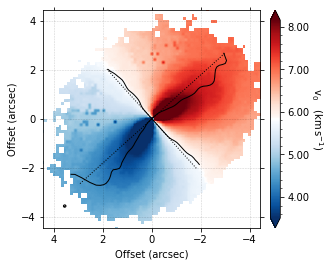

In [4]:
cube.plot_maxima(inc=46.7,PA=312.0, r_max=4.0, smooth=0.3)

In the above figure, the dotted lines show the major and minor axes of the disk based on the `inc` and `PA` values provided. The solid lines show the line of extreme velocities, showing that the emission surface is distinctly elevated. The `smooth` argument smooths the lines to beat down the jitter due to the noise.

This approach is also good for searching for signs of warps or strong radial flows where there should be a significant variation along the minor axis, as discused in [Rosenfeld et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...782...62R/abstract) or [Casassus et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...811...92C/abstract).

### Parameterising the Emission Height

We can go beyond the geometrically thin disk approximation and use a more realistic 3D structure. Here we assume an azimuthually symmetric emission surface parameterized by

$$z(r) = z_0 \times \left( \frac{r - r_{\rm cavity}}{1^{\prime\prime}}\right)^{\psi} \times \exp \left( -\left[ \frac{r_{\rm taper} - r_{\rm cavity}}{1^{\prime\prime}} \right]^{q_{\rm taper}}\right)$$

In this parameterization, $z_0$ is related to the aspect ratio of the emission surface, $\psi$ describes the flaring of this surface, $r_{\rm cavity}$ allows for an inner cavity, such as in a transition disk, and $\{r_{\rm taper},\, q_{\rm taper}\}$ descibe an exponential taper to model the drop in emission height at the edge of the disk. With this description we can recover the geometrically thin limit when $z_0 = 0$ and the conical surface discussed in [Rosenfeld et al. (2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...774...16R) and used with [ConeRot](https://github.com/simoncasassus/ConeRot) with $z_0 > 0$, $\psi = 1$ and $r_{\rm taper} = \infty$.

---

**NOTE:** Previous versions of `eddy` used a double power law described by `z1` and `phi`. The large degeneracy between these parameters strongly favoured a move to this tapered approach (hat tip to Sean Andrews for the suggestion).

---

The coordinate transforms for geometrically thin disks or conical surface are purely analytical so are very quick. For the more complex surfaces this is a slower process. For monotonically increasing surface with a flaring value close to unity, this can be done in an iterative manner. This is the default in `eddy`, and the number of iterations used in the deprojection is set by the `cube.flared_niter` argument, defaulting to 5.

For the more complex surface, particularly those that are not monotonically increasing (i.e., those using the exponential tapered edge), this iterative approach fails ([see the `GoFish` documentation for an example](https://fishing.readthedocs.io/en/latest/user/fishing_coordinates.html#2.2-A-Complex-3D-Example)). To circumvent this, `eddy` also has a slower, but more robust, approach to deprojecting the pixels, invoked with the `'shadowed'` parameter. This builds a 3D model of the emission surface which is then rotated and projected onto the sky.

#### Rotation Direction

Unlike for geometrically thin disks, we can now distinguish the rotation direction of the disk. In `eddy`, this information is encoded in the _sign_ of the inclination we define. We allow the inclination to run from $-90^{\circ}$ to $90^{\circ}$, with negative inclinations representing counter-clockwise rotation and positive inclinations described clockwise rotation. Again, the [`GoFish` documentation](https://fishing.readthedocs.io/en/latest/user/fishing_coordinates.html#3.1-Negative-Inclinations) has examples to demonstrate this.

One problem of this parameterization is that it is very hard for MCMC methods to jump between negative and positive values of inclination. As such, it is recommended to either fix the inclination, and vary stellar mass, or determine the correct sign of the inclination from the `plot_maxima` function.

#### Impact on Velocity Structure

The inclusion of a non-zero height will have two affects. Firstly, it will alter the deprojection which will have most significant difference along the semi-minor axis. Secondly, we have to correct $v_{\rm kep}$ for a) the additional distance to the star from an elevated location (difference in a radial polar coordinate and a radial cylindrical coordinate), and b) the projected gravitational force, resulting in,

$$v_{\rm kep} = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3\,/\,2}}},$$

where $r$ is the cylindrical (or midplane) radius. Note that for the case $z = 0$, this reduced to the same equation used in [Tutorial 1](www.google.com).

### Fitting a 3D Model

With all this in mind, we can try a fit with all these parameters. Note that with the bending of the lobes in the $v_0$ map towards the bottom right of the image, we can infer that the disk is tilted such that that top left edge is closer to the observer, meaning that the disk is rotating in a clockwise direction. As such, we use a _positive_ inclination.

Because we are almost doubling the number of free parameters, and indeed there's a covariance between them, we will use a larger number of walkers to help the convergence of the chains. As such, we're also leveraging the `multiprocessing` package.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr, z0, psi, r_taper, q_taper].


100%|██████████| 2000/2000 [05:45<00:00,  5.79it/s]


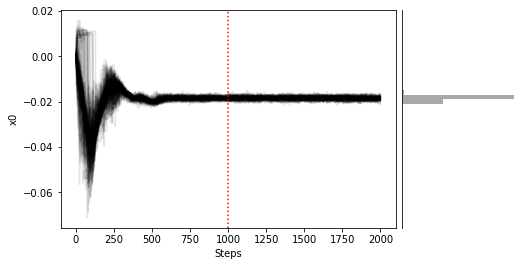

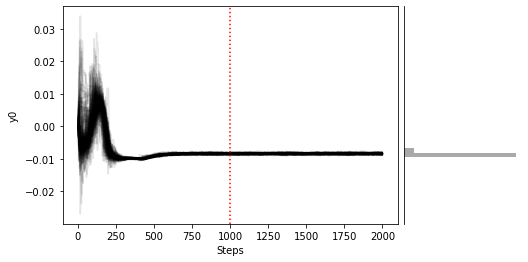

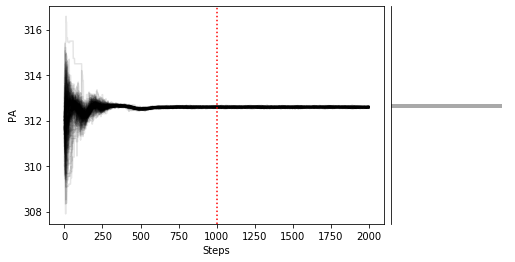

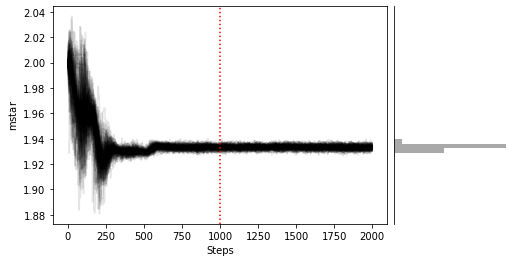

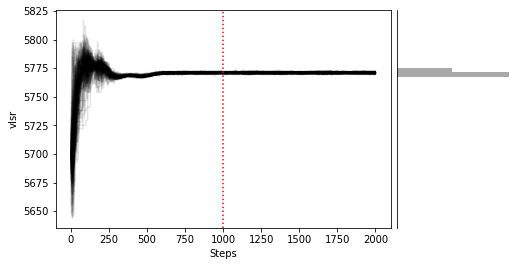

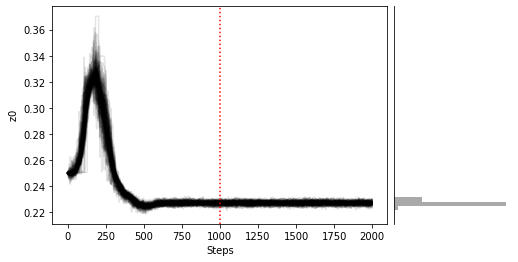

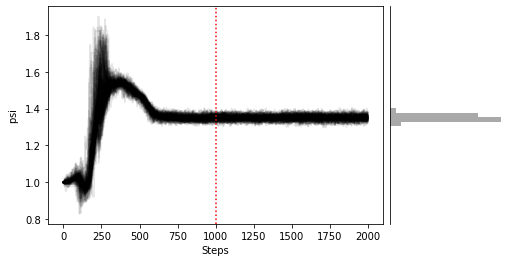

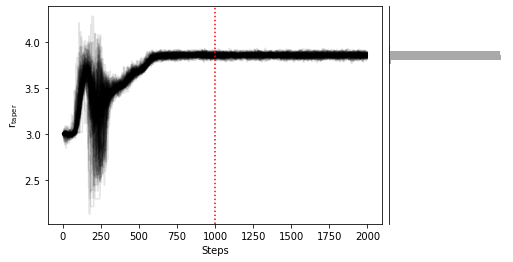

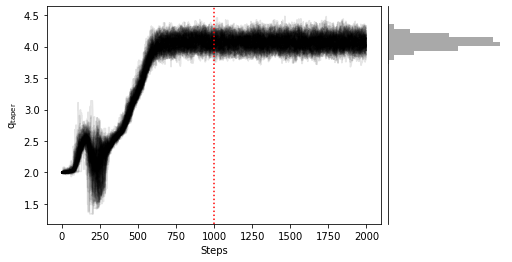

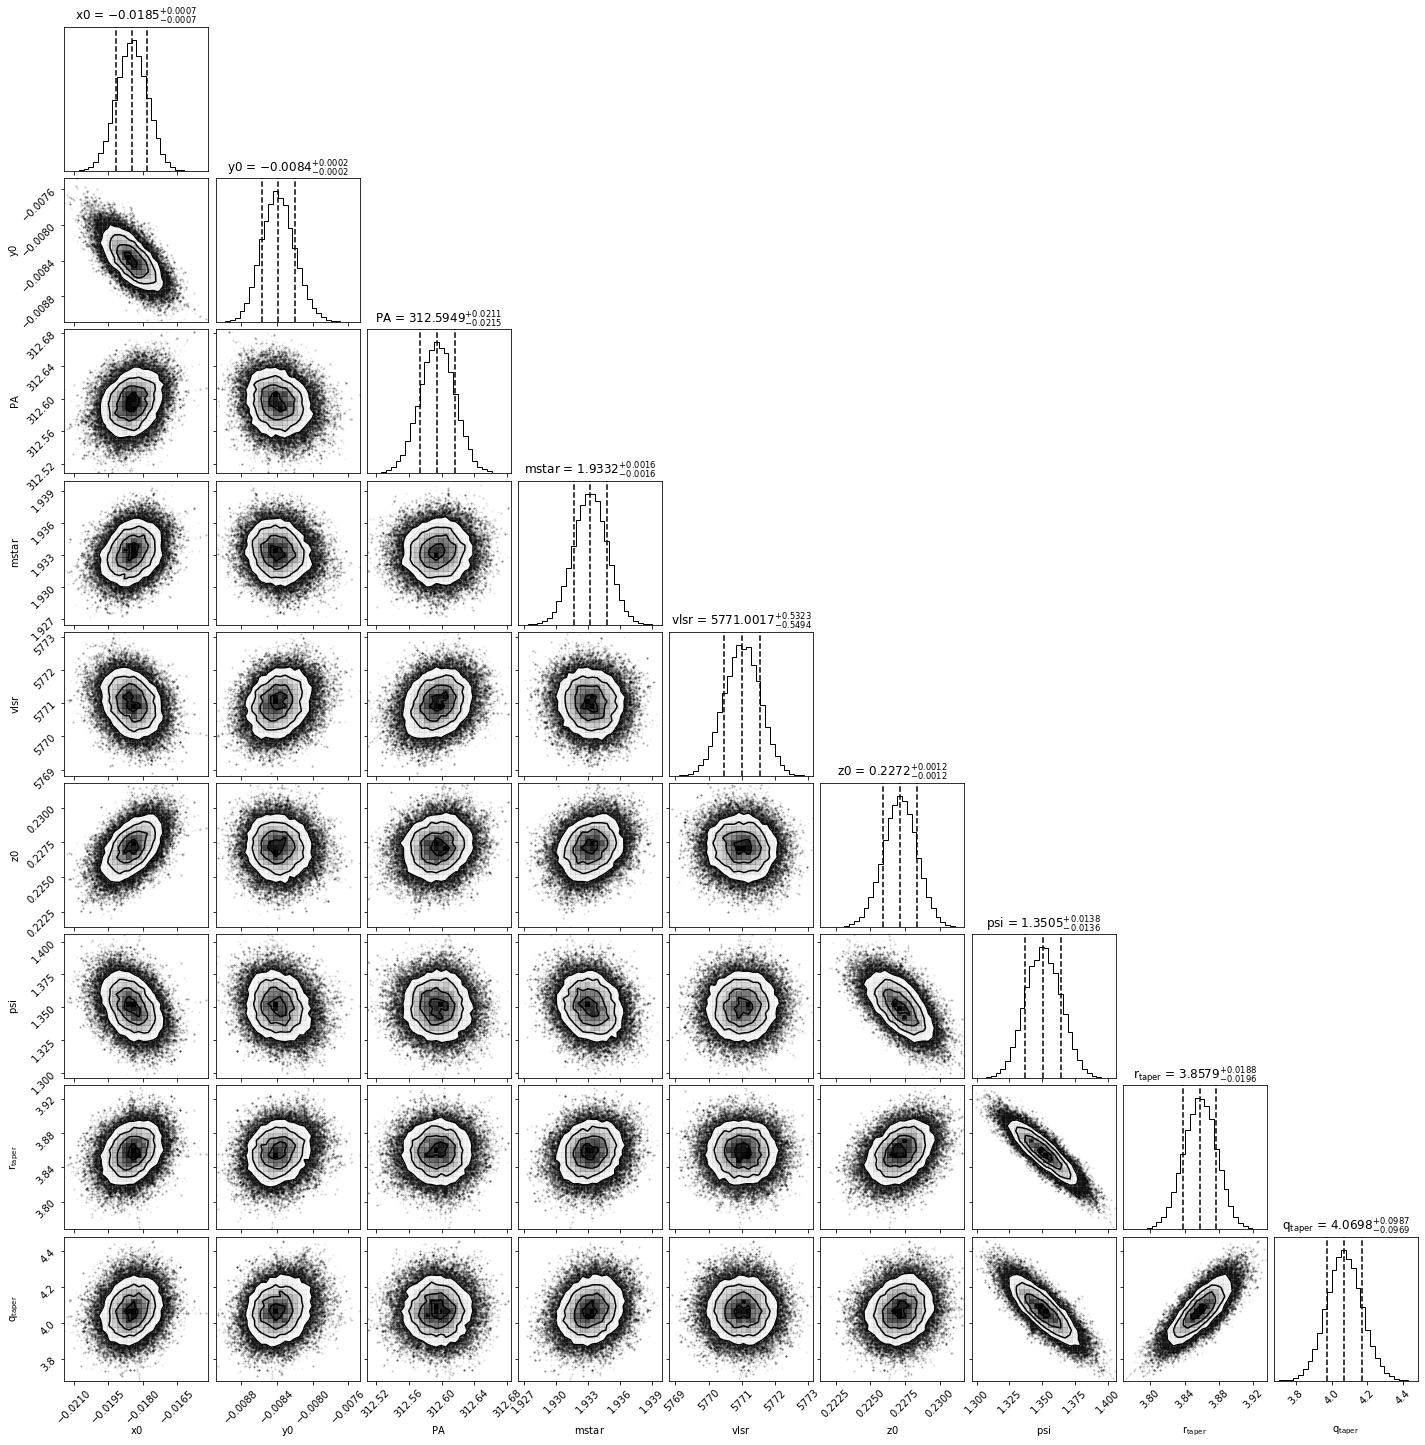

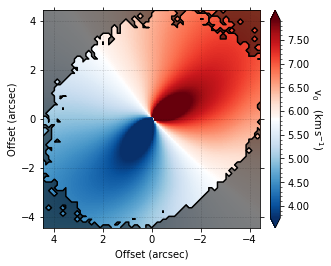

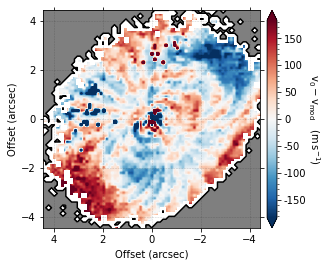

In [5]:
params = {}
params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 312., 2.0, 5.7e3]

params['inc'] = 46.7    
params['dist'] = 101.0

# Include elevated emission surface parameters.

params['z0'] = 5
params['psi'] = 6
params['r_taper'] = 7
params['q_taper'] = 8

p0 += [0.25, 1.0, 3.0, 2.0]

with Pool() as pool:
    samples = cube.fit_map(p0=p0, params=params, optimize=False,
                           nwalkers=128, nburnin=1000, nsteps=1000,
                           pool=pool)

It looks like the chains have converged to a best-fit, and the residuals have definitely improved compared to the 2D fit (the the residuals are $\sim 200~{\rm m\,s^{-1}}$ comapred to the $\sim 300~{\rm m\,s^{-1}}$ of the 2D fit). We still see the arc-like residual along the North Eastern side, but the quadrupole residuals have been suppressed. Instead, we start to see some ordered substructure associated with the kinematic planetary signature identified by [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..13P/abstract) and perturbations in the disk surface density profile [(Teague et al., 2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..12T/abstract).

Interestingly, we do find large positive and negative residuals at the disk edge along the blue-shifted and red-shifted major axes, respectively. This is due to slower rotating gas which [Dullemond et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.137D/abstract) argued was due to the large pressure gradienta the outer edge of the disk.

### Plotting the Emission Surface

Now that we have constrained the emission surface (on the assumption that out model is a reasonable replication of the true source structure), we can overplot the emission surface to check what that looks like. Here we've used the `imshow_kwargs` and `plot_surface_kwargs` to fill the background with the attached data. The `plot_model_surface` is a wrapper for `plot_surface` which is slightly more flexible, but only accepts fixed geometrical properties rather than a (`samples`, `params`) pair.

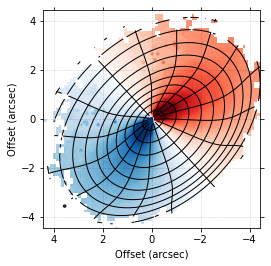

In [6]:
imshow_kwargs = dict(vmin=2.77, vmax=8.77, cmap=cube.cmap())
plot_surface_kwargs = dict(fill='self.data / 1e3',
                           imshow_kwargs=imshow_kwargs)

fig = cube.plot_model_surface(samples, params, plot_surface_kwargs=plot_surface_kwargs)

### Improving the Fit

As we have discussed, a major residual we are seeing is due to the back side of the disk. We can use the masking properties to avoid this region in the fit of the data. As we are cutting down the region we are fitting, it is sensible to reload the data and use a tight `FOV` value.

Assuming uncertainties in ../../cubes/HD163296_CO_dv0.fits.


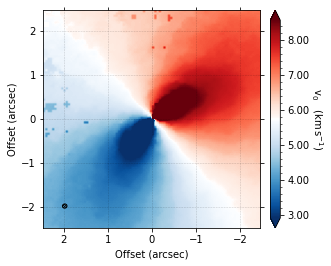

In [7]:
cube = rotationmap(path='../../cubes/HD163296_CO_v0.fits',
                   downsample=4,
                   FOV=5.0)
cube.plot_data()

In [ ]:
params = {}
params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 312., 2.0, 5.7e3]

params['inc'] = 46.7    
params['dist'] = 101.0

params['z0'] = 5
params['psi'] = 6
params['q_taper'] = 7

p0 += [0.25, 1.0, 2.0]

params['r_taper'] = 2.0

# Include a mask that cuts out the backside emisison.

params['r_max'] = 2.8

with Pool() as pool:
    samples = cube.fit_map(p0=p0, params=params, optimize=False,
                           nwalkers=128, nburnin=500, nsteps=[100, 1000],
                           pool=pool, niter=2)

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr, z0, psi, q_taper].


 13%|█▎        | 76/600 [00:19<02:11,  3.98it/s]